# Initializations

In [33]:
import gym
import torch
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from enum import Enum
from collections import deque
from random import random
from copy import deepcopy
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from operator import add
from IPython.display import display, clear_output

# Environment exploration

## Cartpole-v1

### sample components

In [34]:
cartpole_env = gym.make('CartPole-v1')
state = cartpole_env.reset()
print("\n***action***")
print(cartpole_env.action_space)
print("\n***State***")
print(state, cartpole_env.state.shape)
print("observationspace ", cartpole_env.observation_space.shape[0])
print("actionspace," ,cartpole_env.action_space.n)


state, reward, done, _ = cartpole_env.step(cartpole_env.action_space.sample())

print("\n*** reward ***")
print(reward)


***action***
Discrete(2)

***State***
[-0.03997048  0.0464648  -0.0402358  -0.00967559] (4,)
observationspace  4
actionspace, 2

*** reward ***
1.0


### visualizing env

In [ ]:
cartpole_env.reset()
for _ in range(1000):
    cartpole_env.render()
    _, _, done, _ = cartpole_env.step(cartpole_env.action_space.sample())
    if done:
        break
cartpole_env.close()

## LunarLander-v2

### sample components

In [35]:
lun_env = gym.make('LunarLander-v2')
print("\n*** action ***")
print(lun_env.action_space)

state = lun_env.reset()
print("\n*** state ***")
print(state, state.shape)

s, r, done, _ = lun_env.step(lun_env.action_space.sample())

print("\n*** reward ***")
print(r)


*** action ***
Discrete(4)

*** state ***
[-1.0833740e-04  1.4207039e+00 -1.0986023e-02  4.3483603e-01
  1.3230265e-04  2.4884907e-03  0.0000000e+00  0.0000000e+00] (8,)

*** reward ***
-1.2414960081873858


### visualizing env

In [ ]:
lun_env.reset()
for _ in range(1000):
    lun_env.render()
    _, _, done, _ = lun_env.step(lun_env.action_space.sample())
    if done:
        break
lun_env.close()

# DQN-family

## Define q-value architecture

In [2]:

class FCNet(nn.Module):

    def __init__(self, input_size, output_size, hsize=100):
        super(FCNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hsize)
        self.fc2 = nn.Linear(hsize, hsize)
        self.fc3 = nn.Linear(hsize, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

## Define dqn agent

In [3]:

class DqnVannila:
    def __init__(self, sync_steps, buffer_size, gamma, lr, eps, state_size, action_size, batch_size,
                 device, warmup_step=1000, eps_decay=0.999, hsize=100, min_eps=0.0):
        self.sync_steps = sync_steps
        self.max_buffer_size = buffer_size
        self.gamma = torch.tensor(gamma)
        self.lr = lr
        self.eps = eps
        self.buffer = deque()
        self.action_size = action_size
        self.device = device
        self.q = FCNet(state_size, action_size, hsize)
        self.q_target = FCNet(state_size, action_size, hsize)
        self.q.to(self.device)
        self.q_target.to(self.device)
        self.batch_size = batch_size
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.update_step = 0
        self.warmup_step = warmup_step
        self.eps_decay = eps_decay
        self.min_eps = min_eps
        
    def get_q_val(self, qnet, state, action=None):
        if action is None:
            return qnet(state)
        return qnet(state).gather(1, action.reshape(-1,1).long())
        
    def add_to_buffer(self, experience):
        if len(self.buffer) >= self.max_buffer_size:
            self.buffer.pop()
        self.buffer.appendleft(experience)
        
    def _np_to_tensor(self, nparrs):
        return [torch.from_numpy(arr).float().to(self.device) for arr in nparrs]
        
    def sample_minibatch(self):
        idxs = np.random.randint(0, len(self.buffer), self.batch_size)
        sample = [self.buffer[i] for i in idxs]
        
        states, actions, rewards, next_states, dones = list(map(lambda x: np.array(x, dtype=np.float64), zip(*sample)))
        return tuple(self._np_to_tensor([states, actions, rewards, next_states, dones]))
    
    def synchronize(self):
        self.q_target.load_state_dict(self.q.state_dict())
        
    def get_action(self, state, det=False):
        state = torch.from_numpy(state).float().to(self.device)
        if det:
            with torch.no_grad():
                return np.argmax(self.get_q_val(self.q, state).cpu().numpy())
        if random() < self.eps:
            return np.random.randint(0, self.action_size)
        else:
            with torch.no_grad():
                return np.argmax(self.get_q_val(self.q, state).cpu().numpy())
        
    def update(self, state, action, reward, next_state, done):
        self.update_step += 1
    
        self.add_to_buffer([state, action, reward, next_state, done])
        
        #TODO: warmup. should be configurable.
        if len(self.buffer) < self.warmup_step:
            return
        
        #TODO:implement epsilon decay properly
        if done:
            self.eps = max(self.min_eps, self.eps * self.eps_decay)
        
        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = self.sample_minibatch()
        
        with torch.no_grad():
            last_step_target = batch_dones * batch_rewards
            middle_step_target = (1-batch_dones)*(batch_rewards + self.gamma*torch.max(self.get_q_val(self.q_target, batch_next_states), dim=1).values)
            targets =  last_step_target + middle_step_target
        
        predictions = self.get_q_val(self.q, batch_states, batch_actions).squeeze()
        loss = F.mse_loss(predictions, targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.update_step % self.sync_steps == 0:
            self.synchronize()
        


## Define double-dqn agent

In [4]:

class DoubleDQN:
    def __init__(self, buffer_size, gamma, lr, eps, state_size, action_size, batch_size,
                 device, tau=0.99, eps_decay=0.999, min_eps=0.0, warmup_step=1000, hsize=100):
        self.max_buffer_size = buffer_size
        self.gamma = torch.tensor(gamma)
        self.lr = lr
        self.eps = eps
        self.buffer = deque()
        self.action_size = action_size
        self.device = device
        self.q = FCNet(state_size, action_size, hsize)
        self.q_target = FCNet(state_size, action_size, hsize)
        self.q.to(self.device)
        self.q_target.to(self.device)
        self.batch_size = batch_size
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.update_step = 0
        self.tau = tau
        self.min_eps = min_eps
        self.eps_decay = eps_decay
        self.warmup_steps = warmup_step
        
       
        
    def get_q_val(self, qnet, state, action=None):
        if action is None:
            return qnet(state)
        return qnet(state).gather(1, action.reshape(-1,1).long())
        
    def add_to_buffer(self, experience):
        if len(self.buffer) >= self.max_buffer_size:
            self.buffer.pop()
        self.buffer.appendleft(experience)
        
    def _np_to_tensor(self, nparrs):
        return [torch.from_numpy(arr).float().to(self.device) for arr in nparrs]
        
    def sample_minibatch(self):
        idxs = np.random.randint(0, len(self.buffer), self.batch_size)
        sample = [self.buffer[i] for i in idxs]
        
        states, actions, rewards, next_states, dones = list(map(lambda x: np.array(x, dtype=np.float64), zip(*sample)))
        return tuple(self._np_to_tensor([states, actions, rewards, next_states, dones]))
    
    def synchronize(self):
        with torch.no_grad():
            params = self.q.parameters()
            targ_params = self.q_target.parameters()
            for p, p_targ in zip(params, targ_params):
                p_targ.data.mul_(1 - self.tau)
                p_targ.data.add_(self.tau * p.data)
        
    def get_action(self, state, det=False):
        state = torch.from_numpy(state).float().to(self.device)
        if det:
            with torch.no_grad():
                return np.argmax(self.get_q_val(self.q, state).cpu().numpy())
        if random() < self.eps:
            return np.random.randint(0, self.action_size)
        else:
            with torch.no_grad():
                return np.argmax(self.get_q_val(self.q, state).cpu().numpy())
        
    def update(self, state, action, reward, next_state, done):
        self.update_step += 1
        
        self.add_to_buffer([state, action, reward, next_state, done])
        
        if len(self.buffer) < self.warmup_steps:
            return
        
        if done:
            self.eps = max(self.min_eps, self.eps * self.eps_decay)
        
        
        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = self.sample_minibatch()
        
        with torch.no_grad():
            last_step_target = batch_dones * batch_rewards
            
            random_vals = torch.rand(size=(self.batch_size, ), device=self.device)
            rand_mask = random_vals < self.eps
            det_mask = random_vals >= self.eps
            random_actions = torch.randint(low=0, high=self.action_size, size=(self.batch_size, ), device=self.device)
            random_actions[det_mask] = 0
            
            next_actions = torch.argmax(self.get_q_val(self.q_target, batch_next_states), dim=1)
            next_actions[rand_mask] = 0
            
            next_actions = next_actions + random_actions
            middle_step_target = (1-batch_dones)*(batch_rewards + self.gamma*self.get_q_val(self.q, batch_next_states, next_actions).squeeze())
            targets =  last_step_target + middle_step_target
        
        predictions = self.get_q_val(self.q, batch_states, batch_actions).squeeze()
        loss = F.mse_loss(predictions, targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.synchronize()
        


# GridWorld environment

## Defining environment objects

In [5]:
class WorldObj:
    def __init__(self, name):
        self.name = name
        
    def __repr__(self):
        return " "
    
class Empty(WorldObj):
    def __init__(self):
        super().__init__('empty')
    
class Log(WorldObj):
    def __init__(self):
        super().__init__('log')
    
    def __repr__(self):
        return '_'
    
class Gold(WorldObj):
    def __init__(self):
        super().__init__('gold')
    
    def __repr__(self):
        return 'G'
    
class Food(WorldObj):
    def __init__(self):
        super().__init__('food')
    
    def __repr__(self):
        return '8'
    
    
class Trap(WorldObj):
    def __init__(self):
        super().__init__('trap')
        self.state = None
    
    def __repr__(self):
        return 'X'

class Teleport(WorldObj):
    def __init__(self, dest, chance=0.8):
        super().__init__('teleport')
        self.destination = dest
        self.chance = chance
    
    def __repr__(self):
        return 'T'
    
    
class Stream(WorldObj):
    """
    stream only goes down or right!
    """
    
    def __init__(self, _dir: int):
        super().__init__('stream')
        self.dir = _dir
    
    def __repr__(self):
        return '~'
    
class Miner(WorldObj):
    def __init__(self):
        super().__init__('miner')
    
    def __repr__(self):
        return '*'
        

## Defining environment

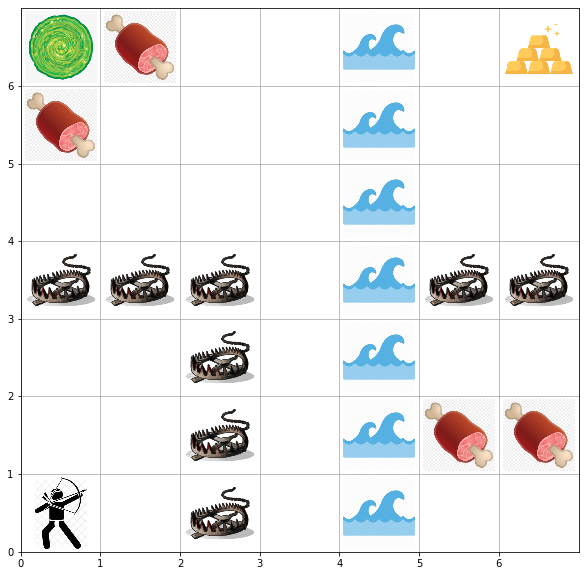

In [6]:
class Action(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3
    LOG_RIGHT = 4
    LOG_DOWN = 5
    LOG_LEFT = 6
    LOG_UP = 7
    
    

class GoldHuntEnv(gym.Env):
    
    metadata = {'render.modes': ['human']}
    static_map_size = 7
    movement_acts = [Action.RIGHT, Action.LEFT, Action.DOWN, Action.UP,]
    craft_acts = [Action.LOG_RIGHT, Action.LOG_LEFT, Action.LOG_DOWN, Action.LOG_UP,]

    def __init__(self, ascii_rep=True, food_prob=0.6, teleport_prob=0.8):
        self.ascii_rep = ascii_rep
        self.action_space = gym.spaces.Discrete(8)
        self.observation_space = gym.spaces.Box(-1, 1, shape=(2,))
        self.info = {}
        self.static_map_size = 7
        self.max_time_step = self.static_map_size * 4
        self.max_reward_size = 10
        self.food_reward = 5 / self.max_reward_size
        self.gold_reward = 10 / self.max_reward_size
        self.time_punishment = -1 / self.max_reward_size
        self.trap_falling_reward = -5 / self.max_reward_size
        self.craft_log_reward = -3 / self.max_reward_size
        self.gold_loc = [6, 6]
        self.food_prob = food_prob
        self.teleport_prob = teleport_prob
        
    def generate_static_map(self, agent_pos):
        env_map = [[Empty() for _ in range(self.map_size)] for _ in range(self.map_size)]
        
        env_map[2][0] = Trap()
        env_map[2][1] = Trap()
        env_map[2][2] = Trap()
        env_map[2][3] = Trap()
        env_map[1][3] = Trap()
        env_map[0][3] = Trap()
        env_map[5][3] = Trap()
        env_map[6][3] = Trap()
        
        env_map[self.gold_loc[0]][self.gold_loc[1]] = Gold()
        
        if self.teleport_prob > 0:
            env_map[0][6] = Teleport(dest=[6,0])
            
        env_map[4][0] = Stream(_dir=Action.LEFT.value)
        env_map[4][1] = Stream(_dir=Action.LEFT.value)
        env_map[4][2] = Stream(_dir=Action.LEFT.value)
        env_map[4][3] = Stream(_dir=Action.LEFT.value)
        env_map[4][4] = Stream(_dir=Action.LEFT.value)
        env_map[4][5] = Stream(_dir=Action.LEFT.value)
        env_map[4][6] = Stream(_dir=Action.LEFT.value)
        
            
        return env_map

    def get_pos_obj(self, pos):
        return self.env_map[pos[0]][pos[1]]

    def stochastic_generation(self, pos, obj, prob):
        if random() < prob:
            self.env_map[pos[0]][pos[1]] = obj
    
    def _get_next_pos(self, current_loc, action):
        action_dir = Action(action)
        next_pos = copy(current_loc)
        
        if action_dir not in self.movement_acts:
            return current_loc
        
        if action_dir == Action.RIGHT:
            next_pos[1] = self._restricted_move(next_pos[1], 1)
        elif action_dir == Action.LEFT:
            next_pos[1] = self._restricted_move(next_pos[1], -1)
        elif action_dir == Action.UP:
            next_pos[0] = self._restricted_move(next_pos[0], -1)
        elif action_dir == Action.DOWN:
            next_pos[0] = self._restricted_move(next_pos[0], 1)
            
        return next_pos
        
        
    def _restricted_move(self, init_val, res):
        new_val = init_val + res
        if new_val >= self.map_size:
            new_val = self.map_size - 1
        elif new_val < 0:
            new_val = 0
        return new_val
    
    
    def pos_to_state(self, pos):
        mapped_pos = [0, 0]
        mapped_pos[0] = pos[0] / (self.map_size/2) - 1
        mapped_pos[1] = pos[1] / (self.map_size/2) - 1
        return np.array(mapped_pos)
    
    def on_border(self, pos):
        if pos[0] == 0 or pos[0] == self.map_size-1 or pos[1] == 0 or pos[1] == self.map_size-1:
            return True
        return False
    
    
    def craft_log(self, current_pos, action: int):
        """
        returns True if log is crafted, False otherwise
        """
        log_loc = self._get_next_pos(current_pos, action-4)
        if log_loc == current_pos or log_loc == self.gold_loc:
            return False
        
        self.agent_pos = log_loc
        self.env_map[log_loc[0]][log_loc[1]] = Log()
        return True
    
    def generate_stochastic_elements(self):
        self.stochastic_generation([1,6], Food(), self.food_prob)
        self.stochastic_generation([0,5], Food(), self.food_prob)
        self.stochastic_generation([1,5], Food(), self.food_prob)
        self.stochastic_generation([5,1], Food(), self.food_prob)
        self.stochastic_generation([5,0], Food(), self.food_prob)
        self.stochastic_generation([6,1], Food(), self.food_prob)
    
    def step(self, action: int):
        self.info['statu'] = ""
        self.info['step'] = self.time_step
        self.time_step += 1
        
        done = self.time_step > self.max_time_step 
        reward = self.time_punishment
        
        self.info['action'] = f"agent performed {Action(action)}"
        curr_obj = self.get_pos_obj(self.agent_pos)
        
        # agent was trapped before
        if isinstance(curr_obj, Trap) and Action(action) in self.movement_acts:
            # this part shows that trap needs memory 
            #             trap_state = curr_obj.state
#             if trap_state is None or action != (trap_state+2)%4:
#                 self.info['status'] = f"Agent in trap with previous action of {None if curr_obj.state is None else Action(curr_obj.state)}"
#                 curr_obj.state = action
#                 self.info['cum_r'] += reward
#                 return self.pos_to_state(self.agent_pos), reward, done, self.info
#             else:
#                 self.info['status'] = f"Agent broke the trap"
#                 self.env_map[self.agent_pos[0]][self.agent_pos[1]] = Empty()
            self.env_map[self.agent_pos[0]][self.agent_pos[1]] = Empty()        
        
        # agent crafts a log
        if Action(action) in self.craft_acts:
            is_crafted = self.craft_log(self.agent_pos, action)
            
            if is_crafted:
                self.info['status'] = 'agent crafted a log'
                reward = self.craft_log_reward
            
            self.info['cum_r'] += reward
            return self.pos_to_state(self.agent_pos), reward, done, self.info
        

        next_pos = self._get_next_pos(self.agent_pos, action)
        next_obj = self.get_pos_obj(next_pos)

        # stream takes agent when he falls into it
        if isinstance(next_obj, Stream):
            self.info['status'] = ('agent fell into a stream')
            while isinstance(next_obj, Stream):
                next_pos = self._get_next_pos(next_pos, next_obj.dir)
                next_obj = self.get_pos_obj(next_pos)
                
                if isinstance(next_obj, Stream) and self.on_border(next_pos):
                    if next_pos[0] == self.map_size-1 and next_pos[1] == self.map_size-1:
                        done = True
                        reward = -20
                    elif next_pos[0] == self.map_size-1 and Action(next_obj.dir) == Action.DOWN:
                        next_pos[1] = self._restricted_move(next_pos[1], 1)
                    elif next_pos[0] == 0 and Action(next_obj.dir) == Action.UP:
                        next_pos[1] = self._restricted_move(next_pos[1], -1)
                    elif next_pos[1] == self.map_size-1 and Action(next_obj.dir) == Action.RIGHT:
                        next_pos[0] = self._restricted_move(next_pos[0], 1)
                    elif next_pos[1] == 0 and Action(next_obj.dir) == Action.LEFT:
                        next_pos[0] = self._restricted_move(next_pos[0], -1)
                    
                next_obj = self.get_pos_obj(next_pos)                              
        
        # gets hurt by falling into trap
        if isinstance(next_obj, Trap):
            self.info['status'] = 'agent fell into a trap'
            reward = self.trap_falling_reward
            
        if isinstance(next_obj, Teleport):
            """ manually non deterministic setup for this env """
            
            if random() <= next_obj.chance:
                self.info['status'] = f'agent teleported to {next_obj.destination} '
                self.agent_pos = next_obj.destination
                self._clear_pos(next_obj.destination)
                return self.pos_to_state(self.agent_pos), reward, done, self.info
        
        # refills energy by eating food
        if isinstance(next_obj, Food):
            self.info['status'] = 'agent ate food!'
            self._clear_pos(next_pos)
            reward = self.food_reward
        
        # agent finds the gold
        if isinstance(next_obj, Gold):
            self.info['status'] = 'agent found the GOLD!'
            done = True
            reward = self.gold_reward
            
        self.agent_pos = next_pos
        self.info['cum_r'] += reward
        
        return self.pos_to_state(self.agent_pos), reward, done, self.info

    def _clear_pos(self, pos):
        self.env_map[pos[0]][pos[1]] = Empty()
    
    def reset(self):
        self.info = {
            'cum_r': 0,
            'action': "",
            'status': "",
            'step': 0
        }
        
        self.map_size = self.static_map_size
        self.agent_pos = [0, 0]
        self.env_map = self.generate_static_map(self.agent_pos)    
        self.generate_stochastic_elements()
        self.prev_action = None
        self.time_step = 0
        
        return self.pos_to_state(self.agent_pos)
  
    def get_env_rep(self):
        env_map_top_layer = deepcopy(self.env_map)
        env_map_top_layer[self.agent_pos[0]][self.agent_pos[1]] = Miner()
        
        return tabulate(env_map_top_layer, headers=[], tablefmt='grid')

    def get_rgb_rep(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(0, self.map_size)
        ax.set_ylim(0, self.map_size)
        
        show_layer = deepcopy(self.env_map)
        show_layer[self.agent_pos[0]][self.agent_pos[1]] = Miner()
        
        for i in range(len(show_layer)):
            for j in range(len(show_layer)):
                obj = show_layer[i][j]
                
                if isinstance(obj, Gold):
                    path = './images/gold.png'
                elif isinstance(obj, Trap):
                    path = './images/trap.png'
                elif isinstance(obj, Food):
                    path = './images/food.png'
                elif isinstance(obj, Log):
                    path = './images/log.png'
                elif isinstance(obj, Stream):
                    path = './images/stream.png'
                elif isinstance(obj, Teleport):
                    path = './images/teleport.png'
                elif isinstance(obj, Miner):
                    path = './images/agent.png'
                else:
                    continue
                    
                
                obj_repr = AnnotationBbox(OffsetImage(plt.imread(path), zoom=0.28),
                       list(map(add, [i, j], [0.5, 0.5])), frameon=False)
                ax.add_artist(obj_repr)
        
        plt.xticks([i for i in range(self.map_size)])
        plt.yticks([i for i in range(self.map_size)])
        plt.grid()
        plt.show()
        
    
    def render(self, mode='human'):
        if self.ascii_rep:
            print(self.get_env_rep())
        else:
            self.get_rgb_rep()
        

    def close(self):
        pass
    
env = GoldHuntEnv(ascii_rep=False)
env.reset()
env.render()

## training dqn on gridworld

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.40it/s]


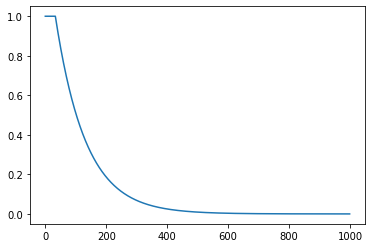

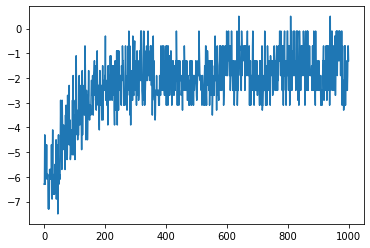

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.15it/s]


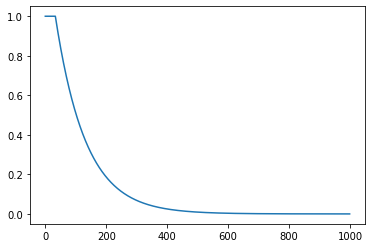

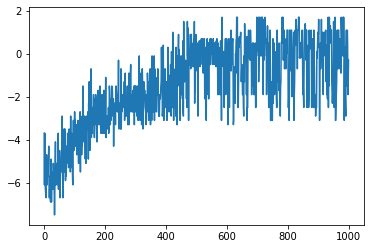

In [10]:
    
def trainDQN(env, agent, epochs=1000):
    done = False
    state = env.reset()
    epsilon_vals = []

    returns = []
    for _ in tqdm(range(epochs)):
        ret = 0
        while not done:
            a = agent.get_action(state)
            next_state, r, done, _ = env.step(a)
            agent.update(state, a, r, next_state, done)
            ret += r
            state = next_state
        done = False
        env.reset()
        epsilon_vals.append(agent.eps) 
        returns.append(ret)

    plt.plot(epsilon_vals)
    plt.show()
    plt.plot(returns)
    plt.show()
    return agent, returns
   

dqn = DqnVannila(
    sync_steps=100,
    buffer_size=5000,
    gamma=0.99,
    lr=0.001,
    eps=1.0,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=32,
    eps_decay=0.99,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
)

ddqn = DoubleDQN(
    buffer_size=5000,
    gamma=0.99,
    lr=0.001,
    eps=1.0,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=32,
    eps_decay=0.99,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
)
    
gold_hunt_env = GoldHuntEnv(ascii_rep=False)
gold_hunt_env.reset()

dqn, history1 = trainDQN(
    env = gold_hunt_env,
    agent=dqn,
)


ddqn, history2 = trainDQN(
    env = gold_hunt_env,
    agent=ddqn,
)

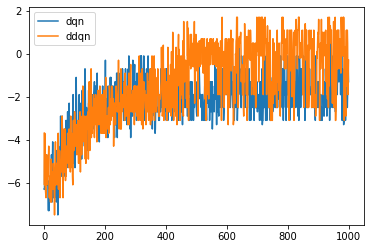

In [12]:
plt.plot(history1)
plt.plot(history2)

plt.legend(['dqn', 'ddqn'])

## evaluation

In [13]:
def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_action(state, det=True)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


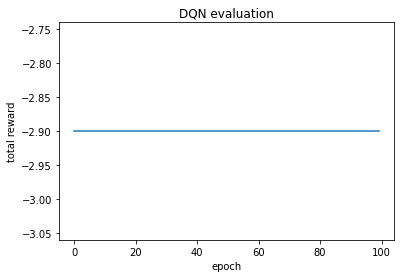

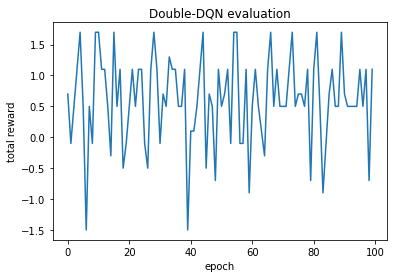

In [14]:
dqn_tot = evaluate_det_policy(env, dqn)
ddqn_tot = evaluate_det_policy(env, ddqn) 

plt.plot(dqn_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('DQN evaluation')
plt.show()


plt.plot(ddqn_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('Double-DQN evaluation')
plt.show()


## investigate the effect of experience replay size

In [ ]:
models = []
returns = []
for buffer_size in [10, 100, 250, 500, 1000, 10000]:
    gold_hunt_env = GoldHuntEnv(ascii_rep=False)
    gold_hunt_env.reset()

    dqn, trainig_returns = trainDQN(
        env = gold_hunt_env,
        buffer_size=buffer_size,
        gamma_val=0.99,
        learning_rate=0.01,
        epsilon_val=0.5,
        batch_size=128
    )
    
    returns.append(trainig_returns)
    models.append(dqn)

In [ ]:
for training_ret in returns:
    plt.plot(training_ret)
plt.xlabel('epoch')
plt.ylabel('cumulative reward')
plt.legend([10, 100, 250, 500, 1000, 10000])

In [ ]:
for model in models:
    average_r = []
    for i in range(10):
        env = GoldHuntEnv(ascii_rep=False)
        state = env.reset()
        done = False
        cum_r = 0
        while not done:
            action = model.get_action(state)
            state, reward, done, info = env.step(action)
            cum_r += reward
        average_r.append(cum_r)
    plt.plot(average_r)
    
plt.xlabel('experiment_number')
plt.ylabel('cumulative reward')
plt.legend([10, 100, 250, 500, 1000, 10000])
plt.show()

## play in environment

In [ ]:
import time

def play(env, agent):
    done = False
    clear_output(wait=True)
    state = env.reset()
    env.render()
    
    while not done:
        action = agent.get_action(state)
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.5)
        
        
play(gold_hunt_env, ddqn)

# Cartpole-v1

## training

In [18]:
def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_action(state, det=True)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


def train_and_evaluate(env, agent, epochs, eval_step=100, early_stop_thr=470, eval_it=50):
    
    returns = []
    epsilons = []
    for i in tqdm(range(epochs)):
        done = False
        state = env.reset()
        
        ret = 0
        while not done:
            a = agent.get_action(state)
            next_state, r, done, _ = env.step(a)
            agent.update(state, a, r, next_state, done)
            ret += r
            state = next_state
        done = False
        epsilons.append(agent.eps)
        returns.append(ret)
        
        if int(i+1)%100 == 0:
            avg_ret = np.mean(evaluate_det_policy(env, agent, k=eval_it))
            print(f"epoch:{i} average return={avg_ret}")
            if avg_ret > early_stop_thr:
                return returns, epsilons
            

    return returns, epsilons



In [19]:
env = gym.make('CartPole-v1')
done = False
state = env.reset()


dqn = DqnVannila(
    sync_steps=100,
    buffer_size=5000,
    gamma=0.99,
    lr=0.001,
    eps=1.0,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=32,
    eps_decay=0.99,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
)

ddqn = DoubleDQN(
    buffer_size=5000,
    gamma=0.99,
    lr=0.001,
    eps=1.0,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=32,
    eps_decay=0.99,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
)


dqn_ret, dqn_eps = train_and_evaluate(env, dqn, epochs=1000)
ddqn_ret, ddqn_eps = train_and_evaluate(env, ddqn, epochs=1000)

  6%|█████████▌                                                                                                                                                          | 58/1000 [00:00<00:01, 501.66it/s]

epoch:99 average return=186.5


 20%|████████████████████████████████▋                                                                                                                                   | 199/1000 [00:13<00:54, 14.66it/s]


epoch:199 average return=500.0


  9%|██████████████▊                                                                                                                                                      | 90/1000 [00:01<00:17, 53.40it/s]

epoch:99 average return=314.84


 21%|██████████████████████████████████▊                                                                                                                                 | 212/1000 [00:22<00:30, 26.17it/s]

epoch:199 average return=9.46


 30%|█████████████████████████████████████████████████▎                                                                                                                  | 301/1000 [00:44<02:23,  4.88it/s]

epoch:299 average return=176.3


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                  | 400/1000 [01:09<05:08,  1.95it/s]

epoch:399 average return=401.78


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 501/1000 [01:24<01:38,  5.07it/s]

epoch:499 average return=149.82


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 596/1000 [01:34<00:11, 33.69it/s]

epoch:599 average return=132.92


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 700/1000 [02:05<03:20,  1.50it/s]

epoch:699 average return=408.38


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 800/1000 [02:53<01:37,  2.04it/s]

epoch:799 average return=284.12


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 899/1000 [03:34<00:24,  4.20it/s]

epoch:899 average return=500.0


### evaluation graphs

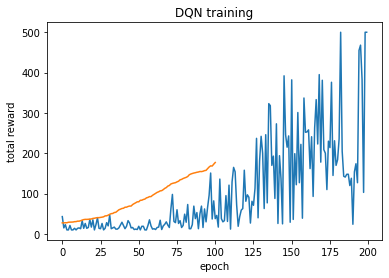

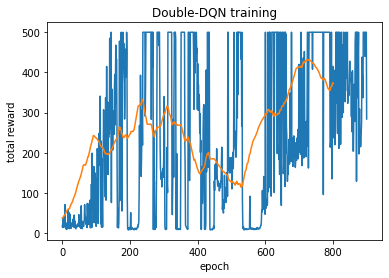

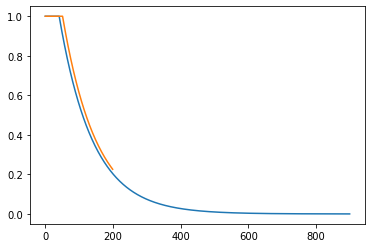

In [20]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


plt.plot(dqn_ret)
plt.plot(moving_average(dqn_ret, n=100))
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('DQN training')
plt.show()


plt.plot(ddqn_ret)
plt.plot(moving_average(ddqn_ret, n=100))
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('Double-DQN training')
plt.show()

plt.plot(ddqn_eps)
plt.plot(dqn_eps)
plt.show()

### simulating environment

In [23]:
import time

def play(env, agent):
    done = False
    clear_output(wait=True)
    state = env.reset()
    env.render()
    
    while not done:
        action = agent.get_action(state, det=True)
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.5)
        
        


In [39]:
play(env, dqn)

{}


2021-11-03 21:01:52.915 python3.8[14168:1455285] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


In [ ]:
play(env, ddqn)

### evaluating with deterministic policy

In [21]:
def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_action(state, det=True)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


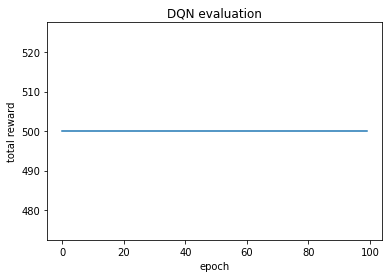

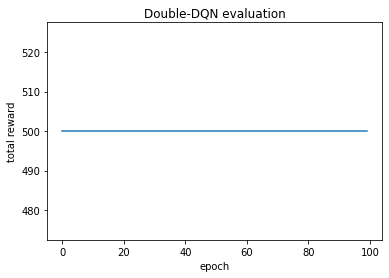

In [22]:
dqn_tot = evaluate_det_policy(env, dqn)
ddqn_tot = evaluate_det_policy(env, ddqn) 

plt.plot(dqn_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('DQN evaluation')
plt.show()


plt.plot(ddqn_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('Double-DQN evaluation')
plt.show()


# LunarLander

## defining agents and training

In [26]:
env = gym.make('LunarLander-v2')
done = False
state = env.reset()


dqn = DqnVannila(
    sync_steps=300,
    buffer_size=10000,
    gamma=0.99,
    lr=3e-4,
    eps=1.0,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=32,
    eps_decay=0.999,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    hsize=100,
    min_eps=0.01,
    warmup_step=1000,
)

ddqn = DoubleDQN(
    buffer_size=10000,
    gamma=0.99,
    lr=3e-4,
    eps=1.0,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=32,
    eps_decay=0.999,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    hsize=100,
    warmup_step=1000,
    min_eps=0.01
)


dqn_ret, dqn_eps = train_and_evaluate(env, dqn, epochs=2000, early_stop_thr=180, eval_it=20)
ddqn_ret, ddqn_eps = train_and_evaluate(env, ddqn, epochs=2000, early_stop_thr=180, eval_it=20)

  5%|████████                                                                                                                                                          | 100/2000 [00:26<1:55:09,  3.64s/it]

epoch:99 average return=-92.39986151160699


 10%|████████████████▎                                                                                                                                                 | 202/2000 [01:01<1:41:13,  3.38s/it]

epoch:199 average return=-64.36356675551453


 15%|████████████████████████▍                                                                                                                                         | 301/2000 [01:28<1:26:54,  3.07s/it]

epoch:299 average return=-111.59206048090513


 20%|████████████████████████████████▉                                                                                                                                   | 401/2000 [01:46<30:12,  1.13s/it]

epoch:399 average return=-189.92046081613216


 25%|█████████████████████████████████████████                                                                                                                           | 501/2000 [02:11<54:34,  2.18s/it]

epoch:499 average return=-221.73755628978734


 30%|████████████████████████████████████████████████▋                                                                                                                 | 601/2000 [03:01<1:54:57,  4.93s/it]

epoch:599 average return=-24.39367922078325


 35%|█████████████████████████████████████████████████████████▍                                                                                                          | 701/2000 [03:47<35:48,  1.65s/it]

epoch:699 average return=144.25640635618907


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                  | 800/2000 [05:03<59:35,  2.98s/it]

epoch:799 average return=152.72217787344877


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                          | 901/2000 [06:31<36:05,  1.97s/it]

epoch:899 average return=111.5856271560693


 50%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 999/2000 [07:39<07:40,  2.17it/s]


epoch:999 average return=198.53573893874318


  5%|████████▎                                                                                                                                                           | 101/2000 [00:13<06:02,  5.24it/s]

epoch:99 average return=-522.1625814077845


 10%|████████████████▍                                                                                                                                                   | 201/2000 [00:29<11:21,  2.64it/s]

epoch:199 average return=-127.13508774343589


 15%|████████████████████████▋                                                                                                                                           | 301/2000 [00:59<49:50,  1.76s/it]

epoch:299 average return=-31.534154636456016


 20%|████████████████████████████████▍                                                                                                                                 | 400/2000 [01:35<2:30:38,  5.65s/it]

epoch:399 average return=-95.5311207301776


 25%|████████████████████████████████████████▌                                                                                                                         | 500/2000 [02:17<2:08:31,  5.14s/it]

epoch:499 average return=-156.43374697330978


 30%|████████████████████████████████████████████████▌                                                                                                                 | 600/2000 [03:27<1:36:37,  4.14s/it]

epoch:599 average return=-220.01046968284777


 35%|████████████████████████████████████████████████████████▋                                                                                                         | 700/2000 [04:44<2:21:15,  6.52s/it]

epoch:699 average return=-80.65264502361899


 40%|████████████████████████████████████████████████████████████████▊                                                                                                 | 800/2000 [07:03<2:38:09,  7.91s/it]

epoch:799 average return=-144.31751836574546


 45%|█████████████████████████████████████████████████████████████████████████▋                                                                                          | 899/2000 [10:31<12:52,  1.42it/s]

epoch:899 average return=212.2738555563998


## performance comparison

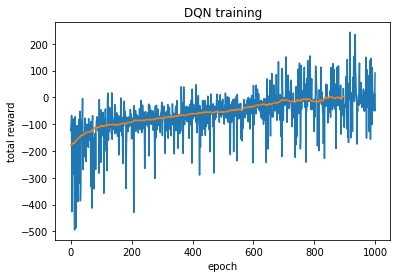

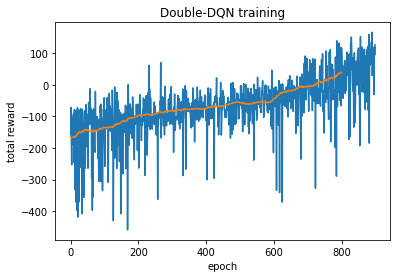

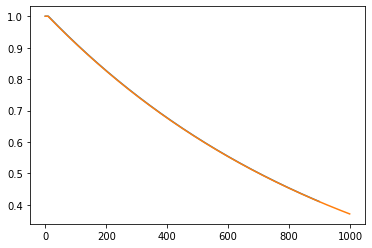

In [27]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n



plt.plot(dqn_ret)
plt.plot(moving_average(dqn_ret, n=100))
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('DQN training')
plt.show()


plt.plot(ddqn_ret)
plt.plot(moving_average(ddqn_ret, n=100))
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('Double-DQN training')
plt.show()

plt.plot(ddqn_eps)
plt.plot(dqn_eps)
plt.show()

### simulating environment

In [28]:
import time

def play(env, agent):
    done = False
    clear_output(wait=True)
    state = env.reset()
    env.render()
    
    while not done:
        action = agent.get_action(state, det=True)
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.5)
        
        


In [ ]:
play(env, dqn)

In [ ]:
play(env, ddqn)

### evaluating with deterministic policy

In [30]:
def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_action(state, det=True)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


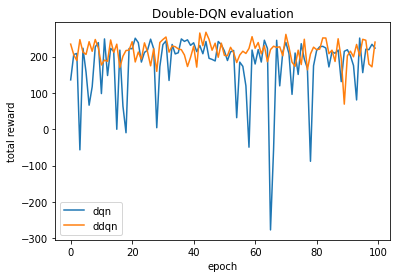

In [31]:
dqn_tot = evaluate_det_policy(env, dqn)
ddqn_tot = evaluate_det_policy(env, ddqn) 

plt.plot(dqn_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('DQN evaluation')

plt.plot(ddqn_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('Double-DQN evaluation')

plt.legend(['dqn', 'ddqn'])

plt.show()
